In [25]:
# set env via .env file
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), verbose=True)

import os
import sys
import pathlib 
import numpy as np
import pandas as pd
import tensorflow as tf
from importlib import reload
import pandas_datareader.data as web
import requests_cache
import datetime
import munch

import math
from cachetools import TTLCache
import time
import ray
import psutil
from sqlalchemy import create_engine
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import qgrid
import mpl_finance as mf

import yfinance as yf
yf.pdr_override()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


import shared
import plot

reload(shared)
reload(plot)

plot = plot.Notebook()

mpl.rcParams['figure.figsize'] = (16, 9)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.unicode_minus']=False
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

cfg = shared.get_config(True)
shared.save_config(cfg)

shared> current directory:/mnt/c/notebooks/sandbox
shared> training period: from '2019-09-10' to '2019-12-03'
shared> download period: from '2019-06-04' to '2019-12-03'
shared> benchmarks: '['000001.SS', '^DJI', '^FCHI', '^GDAXI', '^HSI', '^IXIC', '^N225']'
shared> stocks: '['1COV.DE', 'ADS.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 'BEI.DE', 'BMW.DE', 'CON.DE', 'DAI.DE', 'DB1.DE', 'DBK.DE', 'DPW.DE', 'DTE.DE', 'EOAN.DE', 'FME.DE', 'FRE.DE', 'HEI.DE', 'HEN3.DE', 'IFX.DE', 'LHA.DE', 'LIN.DE', 'MRK.DE', 'MUV2.DE', 'RWE.DE', 'SAP.DE', 'SIE.DE', 'TKA.DE', 'VNA.DE', 'VOW3.DE', 'WDI.DE']'
shared> read from .env: Munch({'config_file_path': '/mnt/c/notebooks/sandbox/config.json', 'cache_dir': '/mnt/c/notebooks/sandbox/cache', 'current_dir': '/mnt/c/notebooks/sandbox', 'start_dt_str': '2019-09-10', 'download_start_dt_str': '2019-06-04', 'end_dt_str': '2019-12-03', 'filter_start_dt_str': '2019-09-10', 'filter_end_dt_str': '2019-12-03', 'benchmarks': ['000001.SS', '^DJI', '^FCHI', '^GDAXI', '^HSI', '^IX

In [6]:
ticker_cfg, df_stocks = shared.download_stocks(cfg)
df_stocks.describe()

[*********************100%***********************]  30 of 30 completed


Adj Close                                                              \
          1COV.DE      ADS.DE      ALV.DE      BAS.DE     BAYN.DE      BEI.DE   
count  128.000000  128.000000  128.000000  128.000000  128.000000  128.000000   
mean   42.869922   273.153516  211.228125  63.435391   63.614844   107.192969   
std    2.220235    8.248026    7.278778    4.111532    5.208221    2.816946     
min    37.950001   255.199997  196.820007  56.200001   52.529999   103.000000   
25%    41.242498   267.450012  206.212502  60.524999   59.587499   105.449997   
50%    43.125000   273.375000  212.000000  62.550001   65.110001   106.575001   
75%    44.752501   279.000008  217.400005  66.234999   67.294998   108.075003   
max    46.950001   296.350006  225.100006  71.480003   71.709999   116.349998   

                                                                               \
           BMW.DE      CON.DE      DAI.DE      DB1.DE      DBK.DE      DPW.DE   
count  128.000000  128.000000  128.000000  128.000000  128.000000  128.000000   
mean   65.910625   120.410156  47.470234   133.436719  6.739227    30.174687    
std    4.381844    6.701309    3.457562    6.166852    0.377648    1.910262     
min    58.700001   104.160004  40.529999   123.500000  5.883000    26.985001    
25%    62.670000   116.995001  45.372500   127.525002  6.480750    28.883750    
50%    64.950001   121.590000  47.597500   134.875000  6.732500    29.677500    
75%    68.662502   124.980001  49.253750   139.100002  7.042250    31.018750    
max    75.040001   132.679993  53.919998   145.500000  7.655000    34.435001    

                                                                               \
           DTE.DE     EOAN.DE      FME.DE      FRE.DE      HEI.DE     HEN3.DE   
count  128.000000  128.000000  128.000000  128.000000  128.000000  128.000000   
mean   15.222734   9.071406    64.290625   45.509610   65.853907   90.881562    
std    0.354337    0.482651    3.814349    2.299105    3.299254    3.624365     
min    14.452000   8.100000    57.919998   40.735001   59.160000   82.320000    
25%    15.047500   8.830750    60.855000   43.881251   63.700002   88.179998    
50%    15.235000   9.002500    63.719999   45.314999   66.540001   91.779999    
75%    15.410500   9.460000    67.454998   47.690001   68.180000   93.779999    
max    16.254000   10.090000   71.239998   49.724998   71.800003   96.660004    

                                                                               \
           IFX.DE      LHA.DE      LIN.DE      MRK.DE     MUV2.DE      RWE.DE   
count  128.000000  128.000000  128.000000  128.000000  128.000000  128.000000   
mean   16.788281   15.240352   175.324570  98.845391   231.992969  25.512109    
std    1.450409    1.311773    6.031469    6.147153    14.211630   1.918173     
min    14.070000   12.845000   164.076874  88.559998   210.000000  21.490000    
25%    15.740000   14.390000   170.669994  93.669998   220.649998  23.897500    
50%    16.488000   14.960000   175.767769  96.219997   226.650002  25.845000    
75%    17.843999   15.831250   178.719524  105.062500  245.874996  27.082500    
max    19.756001   17.905001   188.563065  109.750000  260.600006  28.690001    

                                                                               \
           SAP.DE      SIE.DE      TKA.DE      VNA.DE     VOW3.DE      WDI.DE   
count  128.000000  128.000000  128.000000  128.000000  128.000000  128.000000   
mean   114.328750  100.665469  12.029133   45.205000   156.548906  139.525224   
std    6.370989    8.224131    1.044390    1.773122    13.068889   13.794040    
min    103.339996  85.000000   9.410000    41.820000   138.160004  111.650002   
25%    108.374998  95.654999   11.458750   43.960000   146.205006  122.037502   
50%    113.630001  100.109997  12.167500   44.795000   153.629997  144.981354   
75%    120.460001  105.135002  12.851250   46.869999   169.879997  149.899994   
max    124.379997  117.699997  13.8

In [7]:
horizon_cfg = cfg.train_horizon_config[-1]
dates = next(shared.filter_dates_generator(cfg, horizon_cfg))
dates

Munch({'train_start_dt': datetime.datetime(2019, 9, 10, 0, 0), 'train_end_dt': datetime.datetime(2019, 10, 22, 0, 0), 'predict_start_dt': datetime.datetime(2019, 10, 23, 0, 0), 'predict_end_dt': datetime.datetime(2019, 10, 29, 0, 0)})

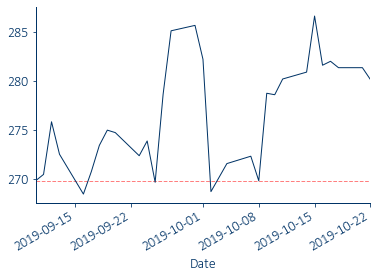

In [8]:
s = shared.get_ticker_feature(df_stocks, 'Adj Close', 'ADS.DE', dates)
s.plot()
plt.hlines(s[0], xmin=s.index[0], xmax=s.index[-1], colors='red', linestyles='dashed', alpha=.5)

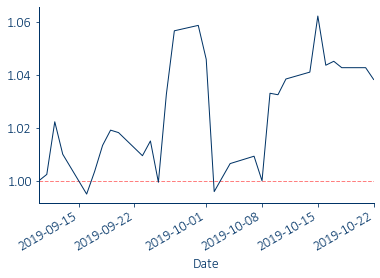

In [9]:
s = shared.get_ticker_feature(df_stocks, 'Adj Close', 'ADS.DE', dates, shared.tf_rel)
s.plot()
plt.hlines(s[0], xmin=s.index[0], xmax=s.index[-1], colors='red', linestyles='dashed', alpha=.5)

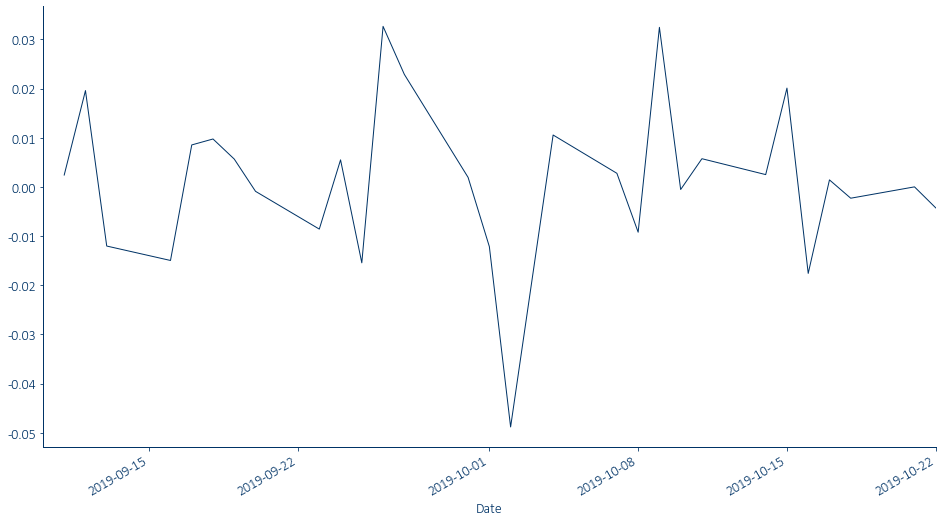

In [18]:
s = shared.get_ticker_feature(df_stocks, 'Adj Close', 'ADS.DE', dates, shared.tf_logdiff)
s.plot()
plt.hlines(s[0], xmin=s.index[0], xmax=s.index[-1], colors='red', linestyles='dashed', alpha=.5)

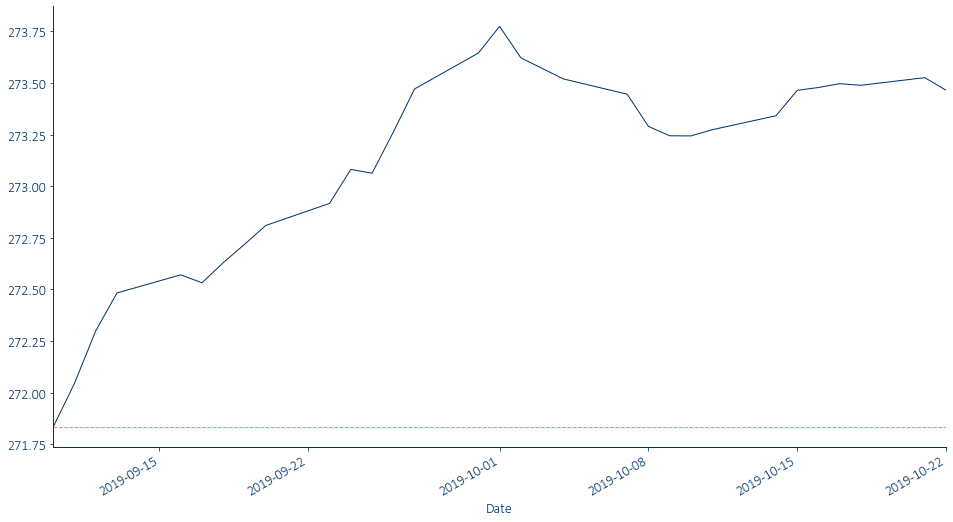

In [27]:
s = shared.get_ticker_feature(df_stocks, 'Adj Close', 'ADS.DE', dates, shared.tf_ma(cfg.window_trading_days[-1]))
s.plot()
plt.hlines(s[0], xmin=s.index[0], xmax=s.index[-1], colors='red', linestyles='dashed', alpha=.5)